In [2]:
import pandas as pd

In [3]:
%run setup.ipynb
%run prep_errors_for_analysis.ipynb

In [4]:
import matplotlib.pyplot as plt

array([[<AxesSubplot:title={'center':'autoreg'}>,
        <AxesSubplot:title={'center':'exp_smooth'}>],
       [<AxesSubplot:title={'center':'ardl'}>,
        <AxesSubplot:title={'center':'xgb_preds'}>],
       [<AxesSubplot:title={'center':'prophet'}>,
        <AxesSubplot:title={'center':'neural_prophet'}>]], dtype=object)

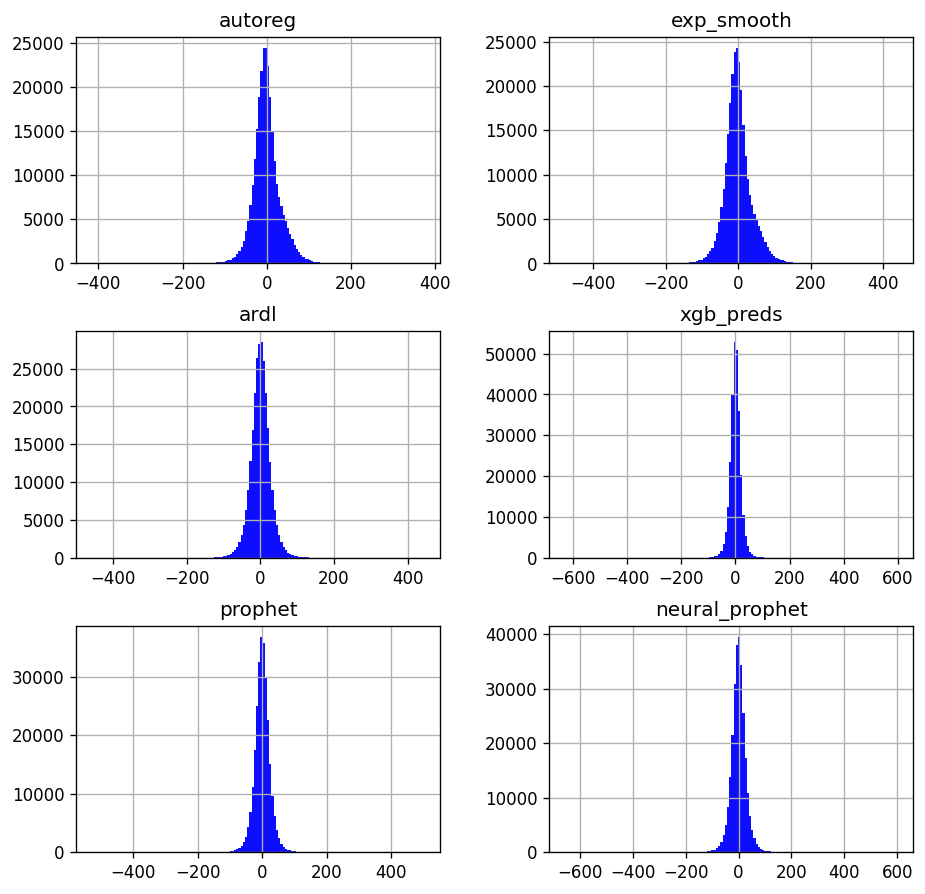

In [5]:
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})

errors.diff().hist(bins=150, facecolor='blue', alpha=0.95, )

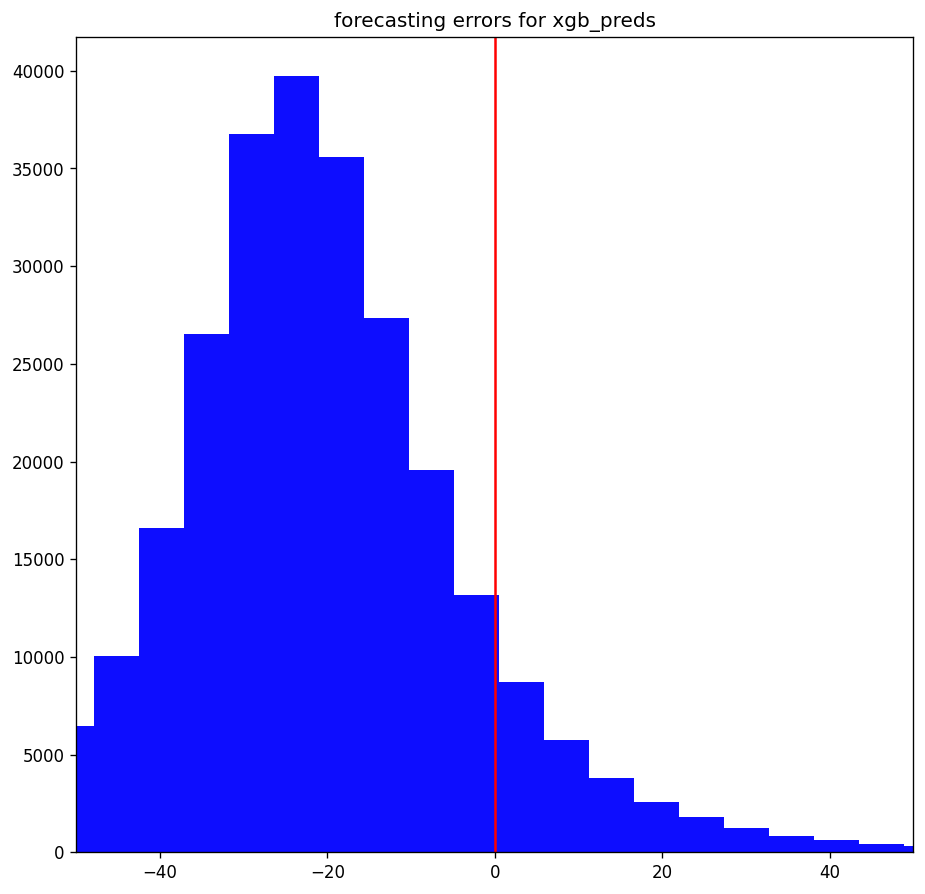

In [6]:
def fcast_errors(col="prophet"):
    plt.hist(errors[col], 150, facecolor='blue', alpha=0.95)
    plt.axvline(x=0, c="red")
    plt.title(f"forecasting errors for {col}")
    plt.xlim((-50, 50))
    plt.show()
    
fcast_errors("xgb_preds")

In [7]:
errors.abs()\
    .mean()\
    .sort_values()
    

prophet           13.628933
ardl              16.232554
exp_smooth        21.166935
neural_prophet    21.665240
autoreg           21.919395
xgb_preds         25.210830
dtype: float64

In [8]:
errors.std()\
    .sort_values()

prophet           18.920430
xgb_preds         20.309274
ardl              21.286953
autoreg           24.097990
neural_prophet    24.810250
exp_smooth        28.616074
dtype: float64

In [9]:
errors

,autoreg,exp_smooth,ardl,xgb_preds,prophet,neural_prophet
0,-2.950508,-0.090401,-19.227368,-25.638563,-10.199980,-6.607513
1,52.004429,54.827076,17.109615,-33.619494,30.847096,37.920719
2,-15.557152,-13.351602,-31.465567,-70.469594,-15.514811,-11.583291
3,24.106558,28.840420,25.196129,-52.514227,22.030022,27.945241
4,-28.478034,-21.299002,-11.820961,-63.722361,-17.893189,-13.790553
...,...,...,...,...,...,...
272401,-14.285714,12.110762,-17.137968,-15.418479,-3.190225,21.452695
272402,-18.079096,8.559487,1.939779,4.096373,10.040482,36.340371
272403,-44.144144,-23.612159,-18.327666,-15.913938,-5.977197,14.964552
272404,-29.569892,-3.996342,12.787682,9.570016,19.459378,44.375635


In [10]:
def fcastplotter(x):
        
    for store in store_sales.store_item.unique():
        temp = store_sales[store_sales.store_item == store]
        plt.figure()
        plt.plot(temp.sales, "-b", label = "sales")
        plt.plot(temp[x],  "-r", label = f"Forecast {x} ")
        plt.legend(loc="upper left")
        plt.ylim([0, None])
        plt.title(f"store {store}")
        plt.show()

In [11]:
for item in predictions.store_item.unique():
    fcastplotter()

TypeError: fcastplotter() missing 1 required positional argument: 'x'